In [1]:
import h5py
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import seaborn as sns

pixel_size = 0.0476
sns.set(rc={'figure.figsize':(8.7,7)})
def gauss(x, A, x0, sigma):
    p = [A, x0, sigma]
    return p[0]*np.exp(-1/2*((x-p[1])/p[2])**2)

def find_size(img_matrix, pixel_size = 0.047724):
    actual_size = tuple(i * pixel_size for i in img_matrix.shape)
    x_pix = np.sum(img_matrix, axis=1)
    y_pix = np.sum(img_matrix, axis=0)
    xs = np.linspace(- actual_size[1]/2, actual_size[1]/2, img_matrix.shape[1])
    ys = np.linspace(- actual_size[0]/2, actual_size[0]/2, img_matrix.shape[0])
    fitX, tmpX = curve_fit(gauss, xs, y_pix, p0=[1,1,1])
    fitY, tmpY = curve_fit(gauss, ys, x_pix, p0=[1,1,1])
    # return sigma of x and y
    return(np.abs(fitX[2]), np.abs(fitY[2]))

def Emit_fit(sizes, ks, err, L = 0.867, quad_L = 0.0718, gamma=36.7651):
    
    sig_square = np.square(sizes/1000)
    fits = np.polyfit(ks, sig_square, deg = 2, w = 1/err)
#     fits = np.polyfit(ks, sig_square, deg = 2)
    
    a_x, b_x, c_x = fits
    
    s11_x = a_x/((L*quad_L)**2)
    s12_x = (b_x - 2 * L * quad_L * s11_x) / (2 * (L**2) * quad_L)
    s22_x = (c_x - s11_x - 2 * L *s12_x) / (L**2)
    
    Emit_x = np.sqrt(s11_x*s22_x-s12_x**2)*gamma*1e6
    beta_x = s11_x/(Emit_x/1e6)*gamma
    gamma_x =s22_x/(Emit_x/1e6)*gamma
    alpha_x =-s12_x/(Emit_x/1e6)*gamma
    return(Emit_x, beta_x, gamma_x, alpha_x)

def BTV_show(img_matrix, pixel_size = 0.0476):
    actual_size = tuple(i * pixel_size for i in img_matrix.shape)
    xs = np.linspace(- actual_size[1]/2, actual_size[1]/2, img_matrix.shape[1])
    ys = np.linspace(- actual_size[0]/2, actual_size[0]/2, img_matrix.shape[0])
    plt.imshow(img_matrix, cmap = "jet", extent=[- actual_size[1]/2, actual_size[1]/2,
                                  - actual_size[0]/2, actual_size[0]/2])
    plt.xlabel("mm")
    plt.ylabel("mm")
    plt.title("BTV42, pixel={:.3f}".format(pixel_size))
#     return ax


# General / Meta data exploration

In [2]:
f = h5py.File("./Solenoid_Quad_WG_230_scan_with_correction1565457611.h5", 'r')

In [3]:
Specs = eval(f['Specs'].value)
ParaLen = Specs['scanParaLen']
nShots = Specs['nShots']
Specs

{'scanParaLen': 77, 'nShots': 10}

In [4]:
list(f.keys())

['BOVWA.01TCV4.CAM8',
 'BOVWA.02TCV4.CAM9',
 'Quad',
 'RPCAH.TSG4.RCIBH.412353',
 'RPCAH.TSG4.RCIBH.430011',
 'RPCAH.TSG4.RCIBV.412353',
 'RPCAH.TSG4.RCIBV.430011',
 'RPSKN.TSG4.SNJ.430001',
 'Solenoid',
 'Specs',
 'TT43.BPM.430010',
 'TT43.BPM.430028',
 'TT43.BPM.430039']

In [5]:
f['BOVWA.02TCV4.CAM9'].value.shape

(77, 10, 240, 384)

In [6]:
df = pd.DataFrame()
d_currents = f['Solenoid'].value
df['Current'] = d_currents
# df['momentum'] = f['Momentum'].value
df['kVal'] = f['Quad'].value
df['xRMS'] = np.zeros(ParaLen)
df['yRMS'] = np.zeros(ParaLen)
df['xRMS_err'] = np.zeros(ParaLen)
df['yRMS_err'] = np.zeros(ParaLen)

for key in ['BOVWA.02TCV4.CAM9']:
    vals = f[key].value
    for i in range(ParaLen):
        #n_vals = vals[i, :, :, :]
        x_rms_s = [find_size(vals[i, idx, :, :])[0] for idx in range(nShots)]
        y_rms_s = [find_size(vals[i, idx, :, :])[1] for idx in range(nShots)]
        df['xRMS'][i] = np.round(np.mean(x_rms_s), decimals = 3)
        df['yRMS'][i] = np.round(np.mean(y_rms_s), decimals = 3)
        df['xRMS_err'][i], df['yRMS_err'][i] = np.std(x_rms_s) , np.std(y_rms_s)

In [7]:
df.describe()

Current       kVal       xRMS       yRMS   xRMS_err   yRMS_err
count   77.000000  77.000000  77.000000  77.000000  77.000000  77.000000
mean   175.000000   1.000000   0.606169   0.807234   0.016938   0.017667
std     10.065574  25.464113   0.512081   0.663115   0.014135   0.018114
min    160.000000 -39.000000   0.087000   0.092000   0.000867   0.001251
25%    165.000000 -23.000000   0.246000   0.278000   0.006671   0.005455
50%    175.000000   1.000000   0.450000   0.609000   0.012895   0.010181
75%    185.000000  25.000000   0.793000   1.105000   0.024328   0.021818
max    190.000000  41.000000   2.552000   2.684000   0.077417   0.078369

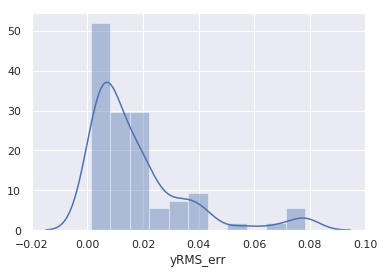

In [8]:
sns.distplot(df["yRMS_err"])

In [9]:
# this is a group in H5
list(f['TT43.BPM.430010'].keys())

['LastAcq#horPos', 'LastAcq#sigma', 'LastAcq#verPos']

In [10]:
for idx in range(Specs['scanParaLen'])[:10]:
    print("Point_{:<2} ".format(idx), end="")
    for key in ['Solenoid', 'Quad']:
         print("{}: {} ".format( key, f[key][idx]), end='')
    print()
print("....")
print(".......")

Point_0  Solenoid: 160.0 Quad: -39.0 
Point_1  Solenoid: 160.0 Quad: -31.0 
Point_2  Solenoid: 160.0 Quad: -23.0 
Point_3  Solenoid: 160.0 Quad: -15.0 
Point_4  Solenoid: 160.0 Quad: -7.0 
Point_5  Solenoid: 160.0 Quad: 1.0 
Point_6  Solenoid: 160.0 Quad: 9.0 
Point_7  Solenoid: 160.0 Quad: 17.0 
Point_8  Solenoid: 160.0 Quad: 25.0 
Point_9  Solenoid: 160.0 Quad: 33.0 
....
.......


# BPM stability check

notice that K values changes BPM reading of 430039, but it's still below 2mm

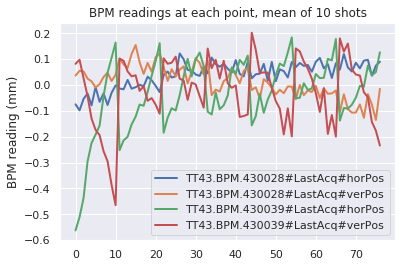

In [11]:
#notice these are groups in H5 file
for key in ['TT43.BPM.430028','TT43.BPM.430039']:
    for entry in list(f['TT43.BPM.430028'].keys())[0:3:2]:
        xs = range(ParaLen)
        ys = np.mean(f[key][entry].value, axis=1)
        plt.plot(xs, ys, linewidth=2, label="{}#{}".format(key, entry))
plt.title("BPM readings at each point, mean of 10 shots")
plt.ylabel("n'th parameter point")
plt.ylabel("BPM reading (mm)")
plt.legend()

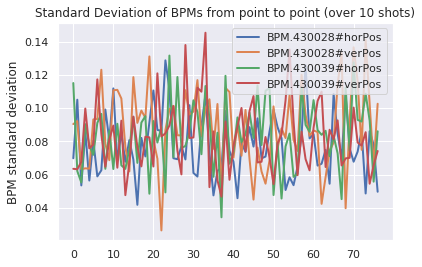

In [12]:
#notice these are groups
for key in ['TT43.BPM.430028','TT43.BPM.430039']:
    for entry in list(f['TT43.BPM.430028'].keys())[0:3:2]:
        xs = range(ParaLen)
        ys = np.std(f[key][entry].value, axis=1)
        plt.plot(xs, ys, linewidth=2, label="{}#{}".format(key[-10:], entry[-6:]))
plt.title("Standard Deviation of BPMs from point to point (over 10 shots)")
plt.ylabel("BPM standard deviation")
plt.legend()

# BTV42 analysis

# Size

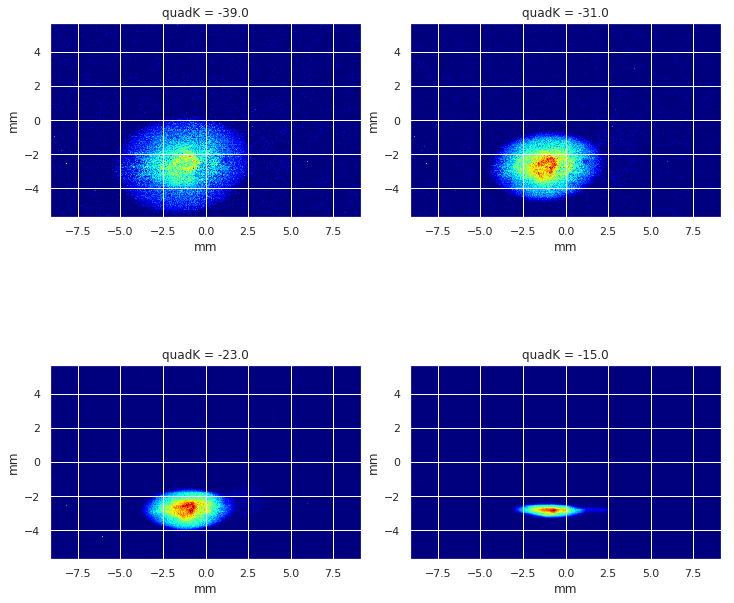

In [20]:
plt.figure(figsize=(10, 10))
for i in range(0,4):
    plt.subplot(2, 2, i+1)
    sample_img = f['BOVWA.02TCV4.CAM9'].value[i, 0, :, :]
    BTV_show(sample_img)
    plt.title("quadK = {}".format(f['Quad'][i]))
plt.tight_layout(pad=0)
#     BTV_show(sample_img) # you can give a pixel_size here

In [14]:
#rms of x and y respectively
find_size(sample_img)

(0.6242212643705596, 0.28363378240998743)

Text(0,0.5,'Y RMS @ BTV42')

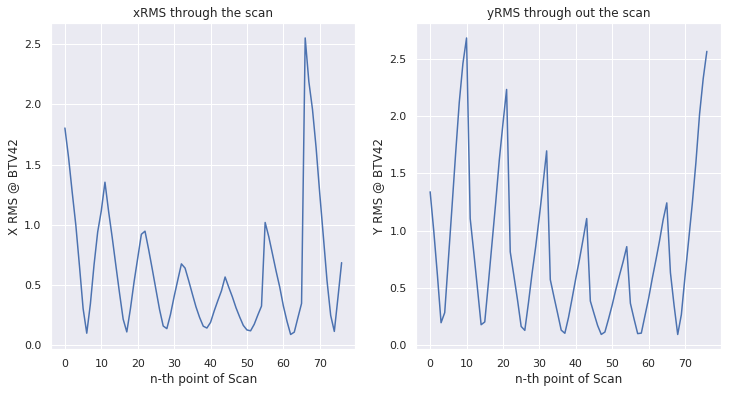

In [15]:
all_imgs = f['BOVWA.02TCV4.CAM9'].value
nShots = Specs['nShots']
Currents = []
kVals = f['Quad']
xSizes = []
ySizes = []
stds = []
for idx in range(Specs['scanParaLen']):
    # nShots of imgs, we do size and std on them
    #print(idx)
    n_imgs = all_imgs[idx, :, :, :]
    xn_sizes = [find_size(n_imgs[x,:,:])[0] for x in range(nShots)]
    yn_sizes = [find_size(n_imgs[x,:,:])[1] for x in range(nShots)]
    xSizes.append(np.mean(xn_sizes))
    ySizes.append(np.mean(yn_sizes))
    #stds.append(np.std(n_sizes))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(ParaLen), xSizes)
plt.title("xRMS through the scan")
plt.xlabel("n-th point of Scan")
plt.ylabel("X RMS @ BTV42")
plt.subplot(1, 2, 2)
plt.plot(range(ParaLen), ySizes)
plt.title("yRMS through out the scan")
plt.xlabel("n-th point of Scan")
plt.ylabel("Y RMS @ BTV42")

Text(0,0.5,'Y emittance @ BTV42')

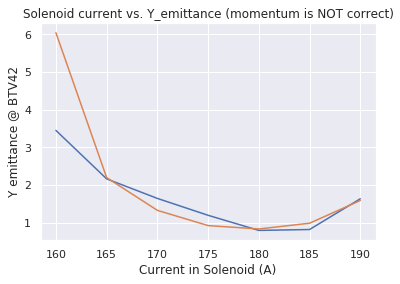

In [16]:
Currents = list(set(df['Current']))
emitXs = []
emitYs = []
numK = 11
half_point = numK
kVals = f['Quad']
kVals = kVals[-numK:]
for cur in Currents:
    temp = df[df['Current'] == cur]
    xs, xerr = temp['xRMS'], temp['xRMS_err']
    ys, yerr = temp['yRMS'], temp['yRMS_err']
    emitXs.append(Emit_fit(xs, temp['kVal'], xerr)[0])
    emitYs.append(Emit_fit(ys, temp['kVal'], yerr)[0])
    
sns.lineplot(Currents, emitXs)
plt.title("Solenoid current vs. X_emittance (momentum is NOT correct)")
plt.xlabel("Current in Solenoid (A)")
plt.ylabel("X emittance @ BTV42")
sns.lineplot(Currents, emitYs)
plt.title("Solenoid current vs. Y_emittance (momentum is NOT correct)")
plt.xlabel("Current in Solenoid (A)")
plt.ylabel("Y emittance @ BTV42")